# Exercise of WIC
Intelligent Embedded Systems Lab, University of Freiburg

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Contact: Lena Uhlenberg lena.uhlenberg@informatik.uni-freiburg.de

March, 2023

## Introduction
In the previous two exercises, we have classified activities using the isolated training samples. 
The data were prepared and cleaned up by the tutor before being offered to you. In practice, the only available data format usually is the raw sensor recording (time series) which contains many artifacts. You need to deal with such data format and reshape them into the supported format that your machine learning models can deal with. 
In this exercise, we perform activity detection directly using raw sensor recordings. 
A challenge is dealing with the non-class, which is a type of class that is usually difficult to be modeled.



## Learning objectives


1. Understand the role of sliding windows in activity detection.
2. Understand the concept of non-class in activity detection.
3. Apply machine learning models to deal with non-class.

## Procedure
1. Follow the notebook and complete the code snippets where required.
2. Answer the questions at the end of the notebook.
3. Submit the notebook after finishing the previous steps.

## Data

We used the raw data collected for the paper
*Florian Wahl, Martin Freund, Oliver Amft, "WISEglass: Smart eyeglasses recognising context", EAI Endorsed Transactions on Pervasive Health and Technology, eudl.eu, 2015*. PDF at the bottom of the page: 
https://www.cdh.med.fau.de/publications/?id=FHX48BI6.<br>

The original dataset includes a number of activities that can be mainly categorized into three classes: "Eating", "Walking", and "Sedentary". 

For example, 

- "Eating" includes breakfast, lunch and dinner; 
- "Walking" includes walking at different speeds and climbing stairs;
- "Sedentary" includes reading, computer work, and watching movie, etc., where participants were sitting. 

The data also contain a **non-class** (some people also call it **null-class**), which is a collection of any other activities beyond the three class, e.g. brushing teeth, biking, cleaning room. Activities in non-class are not our detection target. The original dataset contains data of IMU, heart rate and light sensors. In this exercise, the data have been reduced to only 6-channel IMU (3-axis gyroscope and 3-axis acceleration sensors) and annotated with the three class labels. 

First, we plot the recordings to get an intuitive impression of the data.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


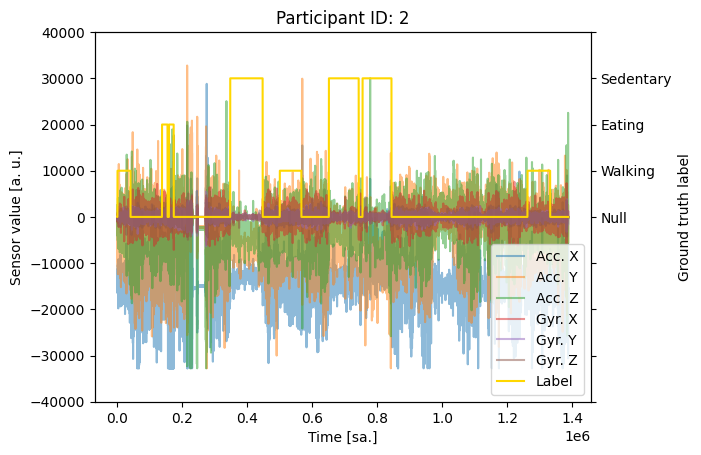

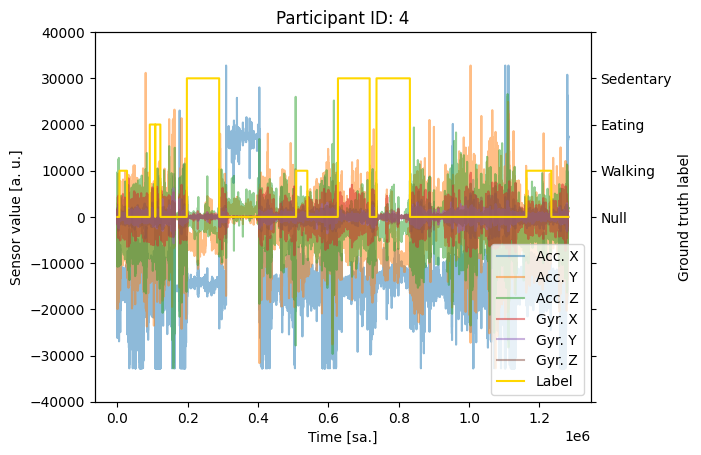

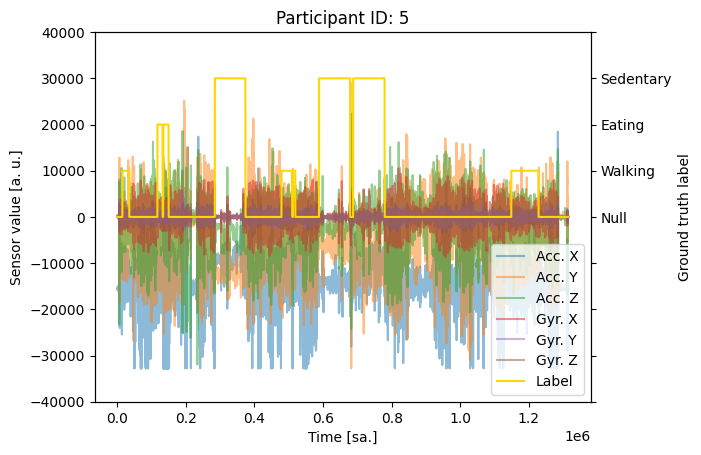

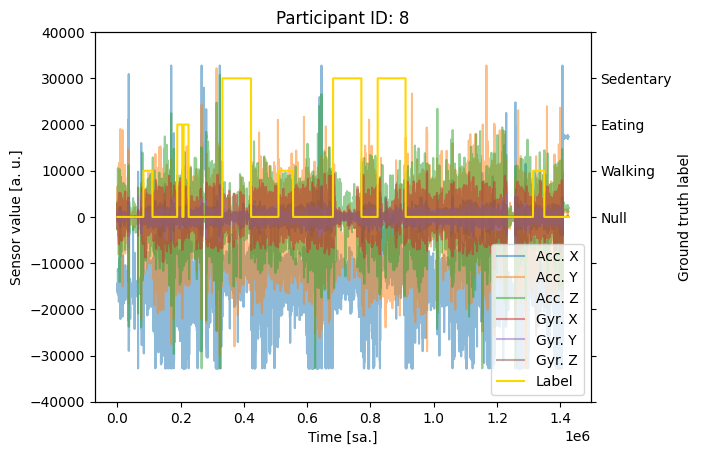

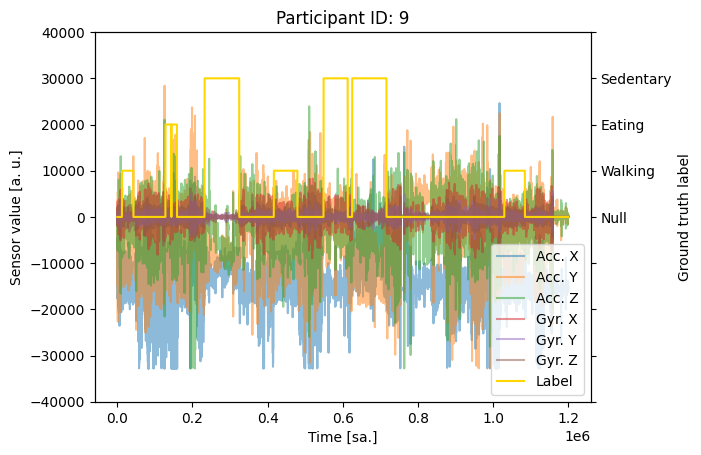

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
import warnings
import _pickle

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load and plot data
for pid in [2, 4, 5, 8, 9]:
    
    # Load data
    hf = h5py.File(r'data/data_E4_TS_' + str(pid) + '.h5', 'r')
    data = hf['data'][:]
    hf.close()
    

    
    # Plot data
    fig, ax1 = plt.subplots()
    ax1.plot(data[:, 0], label='Acc. X', alpha=0.5)
    ax1.plot(data[:, 1], label='Acc. Y', alpha=0.5)
    ax1.plot(data[:, 2], label='Acc. Z', alpha=0.5)
    ax1.plot(data[:, 3], label='Gyr. X', alpha=0.5)
    ax1.plot(data[:, 4], label='Gyr. Y', alpha=0.5)
    ax1.plot(data[:, 5], label='Gyr. Z', alpha=0.5)
    ax1.plot(data[:, 6] * 10000, label='Label', color='gold')
    ax1.legend(loc='lower right')
    ax1.set_title('Participant ID: ' + str(pid))
    ax1.set_xlabel('Time [sa.]')
    ax1.set_ylabel('Sensor value [a. u.]')
    ax1.set_ylim(-40000, 40000)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Ground truth label')
    ax2.set_ylim(-40000, 40000)
    ax2.set_yticklabels(['', '', '', '', 'Null', 'Walking', 'Eating', 'Sedentary'])
    plt.savefig(r'data/Fig_pid_' + str(pid) + '.png')
    del data

As shown in the code and plots, sequentially, the 7 columns of time series are acceleration (x-, y-, and z-axis), gyroscope (x-, y-, and z-axis) and the ground truth labels. 

## Feature extraction and classifier training 
In this session, we will extract features from the training dataset and train a classifier.
Data used for training are the segments with one of the following labels: "Eating", "Walking", and "Sedentary". 
As in the following provided code, a sliding window steps over training data segments with a window size of 1500 samples (30 s) and a step size of 750 samples (15 s). You can later vary the step size and window size keeping one rule in mind, that the window size used for training and test should stay consistent. 

Feature vectors will be standardized or normalized before training and testing. There are several reasons of doing this, which are well-explained e.g. in this link: https://scikit-learn.org/stable/modules/preprocessing.html. Feature engineering is a very important topic that usually cannot be skipped if you want to achieve better detection performance. Among a number of available techniques, feature selection and recreation are common practice. One principle of feature selection, is to include features of large inter-classes variance. There are a number of feature selection APIs from scikit-learn, e.g. https://scikit-learn.org/stable/modules/feature_selection.html. You are encouraged to design and append your own features to the feature vector. This might help to improve the classification performance in case of model under-fitting, for example.

Try to extract features and train a classifier. Keep in mind your goal is to achieve as high detection accuracy as possible. Based on your knowledge and experience from exercise E3, you need to decide what features to include or exclude and what classifiers to use. Features are extracted with the following function, you can make changes to the function, e.g. adding or removing features.

In [2]:
clf_list, win_len, win_step = [], 1500, 50 # len = 30 seconds, step = 1s change values here

# Feature extraction function
def feature_cal(window):
    # print(len(window))
    fv = []
    x = np.array(window).T
    for i in range(x.shape[0]):
        # if(len(x[i]) == 0):
        #     ret_val = np.zeros(120)
        #     return ret_val
        mean_ = np.mean(x[i])
        std_ = np.std(x[i])
        max_ = np.max(x[i])
        min_ = np.min(x[i])
        zcr_ = (np.diff(np.sign(x[i])) != 0).sum() #zero-crossing rate
        fluc_ = mean_ / std_
        min_max_ = max_ - min_
        sum_ = np.sum(x[i])
        pos_sum_ = np.sum(x[i][x[i] > 0])
        neg_sum_ = np.sum(x[i][x[i] < 0])
        abs_sum_ = np.sum(np.abs(x[i]))
        diff_sum_ = np.sum(np.diff(x[i])) # fist derivative
        diff_pos_sum_ = np.sum(np.diff(x[i])[np.diff(x[i]) > 0])
        diff_neg_sum_ = np.sum(np.diff(x[i])[np.diff(x[i]) < 0])
        diff_diff_sum_ = np.sum(np.diff(np.diff(x[i]))) #second derivative
        diff_diff_abs_sum_ = np.sum(np.abs(np.diff(np.diff(x[i]))))
        diff_diff_pos_sum = np.sum(np.diff(np.diff(x[i]))[np.diff(np.diff(x[i])) > 0])
        diff_diff_neg_sum = np.sum(np.diff(np.diff(x[i]))[np.diff(np.diff(x[i])) < 0])
        rms_ = np.sqrt(np.sum(x[i]**2))# root mean square
        energy_ = np.sum(x[i]**2) / win_len # area below curve

        fv.extend([mean_, std_, max_, min_, zcr_, fluc_, min_max_, sum_, 
                   pos_sum_, neg_sum_, abs_sum_, diff_sum_, diff_pos_sum_, 
                   diff_neg_sum_, diff_diff_sum_, diff_diff_abs_sum_, 
                   diff_diff_pos_sum, diff_diff_neg_sum, rms_, energy_])
    ret_val = np.array(fv)
    # print(ret_val.shape)
    return ret_val

In [3]:
# Sliding window implementation
for test_pid in [2, 4, 5, 8, 9]:
    pid_pool = [2, 4, 5, 8, 9]
    pid_pool.remove(test_pid)
    x_train, y_train = [], []
    for train_pid in pid_pool:
        
        # Load data
        hf = h5py.File(r'data/data_E4_TS_' + str(pid) + '.h5', 'r')
        train_data = hf['data'][:]
        hf.close()

        # Split training data by class
        c1, c2, c3 = [], [], []
        for i in range(len(train_data)):
            if train_data[i, 6] == 1:
                c1.append(train_data[i, :6])
            elif train_data[i, 6] == 2:
                c2.append(train_data[i, :6])
            elif train_data[i, 6] == 3:
                c3.append(train_data[i, :6])

        class_id = 1
        for c in [c1, c2, c3]:
            j = 0
            for i in range(len(c)):
                if j > len(c) - win_len - 1:
                    break
                else:
                    data_slice = c[j: j + win_len]
                    # print(len(data_slice))
                    x_train.append(feature_cal(data_slice))
                    y_train.append(class_id)
                    j += win_step
            class_id += 1

    x_normalized, max_norm, min_norm = [], [], []

    for col in range(len(x_train[0])):
        f_i = np.array([row[col] for row in x_train])
        max_norm.append(np.max(f_i))
        min_norm.append(np.min(f_i))
    max_norm = np.array(max_norm)  
    min_norm = np.array(min_norm)
    x_normalized = (x_train - min_norm) / (max_norm - min_norm)

    select_model =  SelectKBest(chi2, k=9) #"SELECT YOUR FEATURE SELECTION MODEL HERE" #e.g. KBest
    fitted = select_model.fit(x_normalized, y_train)
    scores = fitted.scores_
    x_train = fitted.transform(x_normalized)
    
    # Train classifier
    clf = RF() #"DEFINE YOUR MODEL HERE" # e.g. random forest
    clf.fit(x_train, y_train)
    print('Model ' + str([2, 4, 5, 8, 9].index(test_pid) + 1) + ': ')
    print(clf)
    clf_list.append(clf)
    del x_train, y_train, x_normalized

#-------------------------------------------------------------------------------------
    # Save classifier model to file, models will be useful for the next exercise E5.
    with open(r'data/dumped_classifier_pid_' + str(test_pid) + '.pkl', 'wb') as f:
        _pickle.dump(clf, f)        
        
    # Save feature selector model
    with open(r'data/feature_selector_pid_' + str(test_pid) + '.pkl', 'wb') as f:
        _pickle.dump(select_model, f)   
        
    # Save feature normalization parameter
    with open(r'data/feature_norm_para_pid_' + str(test_pid) + '.pkl', 'wb') as f:
        _pickle.dump([max_norm, min_norm], f)

Model 1: 
RandomForestClassifier()
Model 2: 
RandomForestClassifier()
Model 3: 
RandomForestClassifier()
Model 4: 
RandomForestClassifier()
Model 5: 
RandomForestClassifier()


## Online detection
You will soon test your classifier **online** with a piece of data that your classifier has never "seen" during training. Here **online** means to simulate real-time sensor streams by applying a sliding window to the raw sensor data, as if the data in the window were freshly recorded and delivered to your classifier. 

As there are many non-class samples in the test dataset and our detector models were not trained using non-class, we will apply a threshold on the posteriors yielded by the classifier. If the maximal of the three (class) posteriors is lower than the threshold, we regard the sample as non-class. 

Keep in mind, training set and test set should be treated equally. E.g. if you standardized features in the training set, you should also standardize features in the test set.

C:\Users\sansk\AppData\Local\Temp\ipykernel_5744\1358906709.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  fluc_ = mean_ / std_


Current LOPO fold accuracy: 39.8%.


e:\UniFreiburg\Semester 2\EC_Wireless and Implantable Computing\Exercise\e1_1_naive_bayes\wic\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


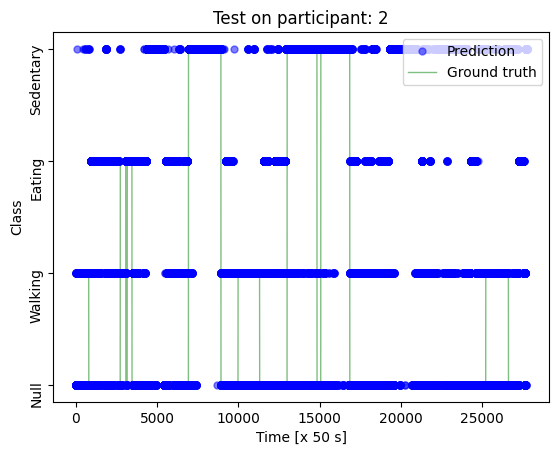

____________________________________________________________


C:\Users\sansk\AppData\Local\Temp\ipykernel_5744\1358906709.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  fluc_ = mean_ / std_
e:\UniFreiburg\Semester 2\EC_Wireless and Implantable Computing\Exercise\e1_1_naive_bayes\wic\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Current LOPO fold accuracy: 37.2%.


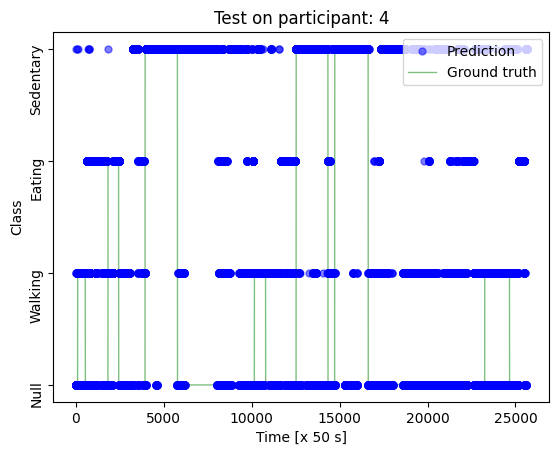

____________________________________________________________
Current LOPO fold accuracy: 53.9%.


C:\Users\sansk\AppData\Local\Temp\ipykernel_5744\1358906709.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  fluc_ = mean_ / std_
e:\UniFreiburg\Semester 2\EC_Wireless and Implantable Computing\Exercise\e1_1_naive_bayes\wic\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


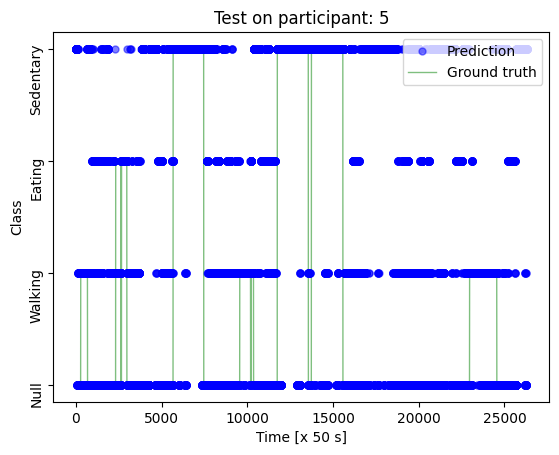

____________________________________________________________
Current LOPO fold accuracy: 25.9%.


C:\Users\sansk\AppData\Local\Temp\ipykernel_5744\1358906709.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  fluc_ = mean_ / std_
e:\UniFreiburg\Semester 2\EC_Wireless and Implantable Computing\Exercise\e1_1_naive_bayes\wic\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


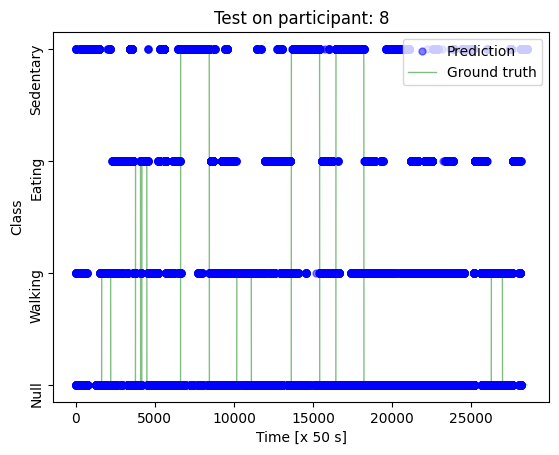

____________________________________________________________
Current LOPO fold accuracy: 50.9%.


C:\Users\sansk\AppData\Local\Temp\ipykernel_5744\1358906709.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  fluc_ = mean_ / std_
e:\UniFreiburg\Semester 2\EC_Wireless and Implantable Computing\Exercise\e1_1_naive_bayes\wic\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


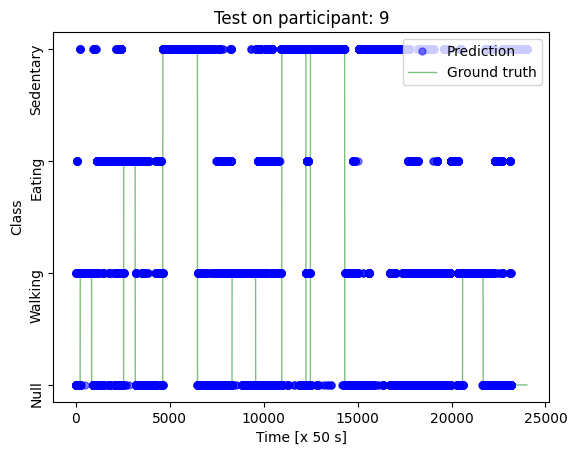

____________________________________________________________


In [8]:
# Online detection implementation, i.e. test.
clf_index, accuracy, win_len, win_step = 0, [], 1500, 50 # e.g. len = 30 seconds, step = 1s.
import pickle

# Creating lists of ground truth and detection
ground_truth_list, result_list = [], [] 

for test_pid in [2, 4, 5, 8, 9]:
    
    # Simulate online test
    hf = h5py.File(r'data/data_E4_TS_' + str(test_pid) + '.h5', 'r')
    test_data = hf['data'][:]
    hf.close()
    j, result, ground_truth = 0, [], []
    
    for i in range(len(test_data) - win_len):
        test_data_slice = test_data[j: j + win_len]
        # print(len(test_data_slice))
        
        # majority vote of the ground truth label in the window
        ground_truth.append(Counter(test_data_slice[:, 6]).most_common(1)[0][0])
        # TODO  : USE FUNCTION feature_cal
        test_data_slice = test_data_slice[:, :6]
        feature_vec = feature_cal(test_data_slice) #"USE FUNCTION feature_cal"
        # print(feature_vec.shape, min_norm.shape, max_norm.shape)
        # with open(r'data/feature_norm_para_pid_' + str(test_pid) + '.pkl', 'rb') as f:
        #     scaler = pickle.load(f)
        # # test_norm = np.asarray([(feature_vec - min_norm) / (max_norm - min_norm)])
        # test_norm = scaler.transform([feature_vec])
        test_norm = (feature_vec - min_norm) / (max_norm - min_norm)
        # if np.any(np.isnan(test_norm)) or np.any(np.isinf(test_norm)) or np.any(test_norm == 0):
        #     continue
        test_norm = test_norm[~np.isnan(test_norm)].reshape(1, -1)
        
        # Handle cases where the data is nan or inf
        if test_pid==4:
            a=np.isnan(test_norm)
        test_norm = np.clip(test_norm, np.finfo(np.float64).min, np.finfo(np.float64).max)

        test = select_model.transform(test_norm)
        clf = clf_list[clf_index]
        prediction = clf.predict(test)
        
        # You can change the prediction probability threshold (i.e. 0.6) here
        if clf.predict_proba(test).max() > 0.85: 
            result.append(prediction[0])
        else:
            result.append(0)
        j += win_step
        if j > len(test_data - win_len - 1):
            break
        else:
            continue
    clf_index += 1
    accuracy.append(accuracy_score(result[0:1500], ground_truth[0:1500])) # one-fold
    print('Current LOPO fold accuracy: ' + str("%.1f" % (accuracy[-1] * 100)) + '%.')
    
    # Plots
    fig = plt.figure()
    plt.plot(result, 'bo', markersize=5, linewidth=1, label='Prediction', alpha=0.5, zorder=1)
    plt.plot(ground_truth, 'g', linewidth=1, label='Ground truth', zorder=0, alpha=0.5)
    plt.xlabel('Time [x ' + str(win_step) + ' s]')
    plt.ylabel('Class')
    plt.yticks([0, 1, 2, 3], ['Null', 'Walking', 'Eating', 'Sedentary'], rotation='vertical')
    plt.title('Test on participant: ' + str(test_pid))
    plt.legend(loc='upper right')
    plt.show()
    print('_' * 60)
    ground_truth_list.append(ground_truth)
    result_list.append(result)      
    del test_data 

# Flatten lists
result_list = [item for sublist in result_list for item in sublist]
ground_truth_list = [item for sublist in ground_truth_list for item in sublist]

Try to change the prediction probability threshold (e.g. to 0.5, 0.7, 0.9) in the above code block and observe how the performance changes after evaluation. Consider, does it make sense to set the threshold to e.g. 0.3?

## Evaluation
To evaluate you detector, you can check the accuracy and the confusion matrix.

Average accuracy of LOPO cross-validation: 41.5%.


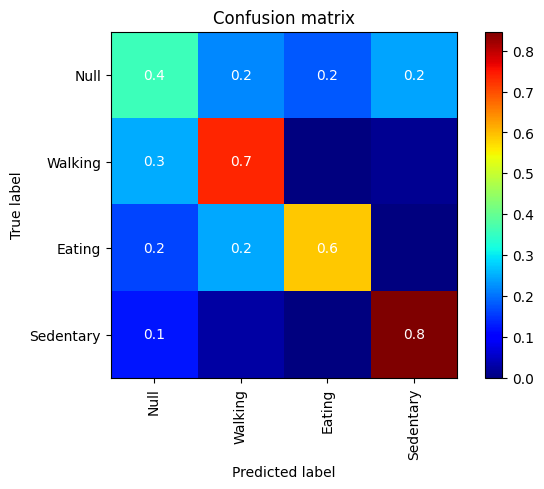

In [9]:
# Evaluation: accuracy
print('Average accuracy of LOPO cross-validation: ' + str("%.1f" % (np.mean(accuracy) * 100)) + '%.')

# Confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names, title='Confusion matrix', cmap=plt.cm.jet, annotate_threshold=0.1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    cax = ax.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for col in range(confusion_matrix.shape[1]):
        for row in range(confusion_matrix.shape[0]):
            if round(confusion_matrix[row, col], 1) >= annotate_threshold:
                ax.text(col, row, str(round(confusion_matrix[row, col], 1)), va='center', ha='center', color='white')
    return fig

f = plot_confusion_matrix(metrics.confusion_matrix(ground_truth_list, result_list), ['Null', 'Walking', 'Eating', 'Sedentary'])


## Questions

Please answer directly in this code block.

#### 1. Why did we train the classifier without using the null-class? 
Answer: The null-class represents periods of inactivity. By excluding it during training, the focus is on detecting specific activities of interest.

#### 2. What strategy was used to deal with the null-class in pattern recognition in this exercise? 
Answer: A prediction probability threshold was set. If the maximum prediction probability is above the threshold, it's considered a valid prediction for an activity class; otherwise, it's assigned the null-class label.

#### 3. What are the sliding window parameters? How do the parameters influence the detection algorithm regarding execution time and detection performance in the exercise? 
Answer: The sliding window parameters are win_len (window length) and win_step (step size). Smaller window lengths and larger step sizes reduce execution time but may sacrifice detection accuracy. Larger window lengths improve detection accuracy but increase computational burden.

#### 4. Based on your exploration, what can be done to improve the detection performance?
Answer: To improve detection performance, consider:

* Exploring different feature selection techniques.
* Experimenting with different classification models.
* Tuning hyperparameters of the chosen model.
* Augmenting the training dataset.
* Employing ensemble methods.
* Incorporating contextual information.
* Using fine-grained labels if available.
These strategies can be explored individually or in combination to enhance the detection performance based on the specific requirements of the activity detection task.


## Submission
Make sure all coding tasks are completed, code blocks are executed, and all questions are answered.<br>
Enter your name(s) and matriculation number(s) here:<br>
**Name(s)**: Sanskar Biswal, Sidharth Suresh                           <br>
**Matriculation number(s)**: 5585853, 5583120                             <br>